In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import math
import random

# targeted time in seconds
SEQUENCE_TIME = 5.0
# minimum time of path to be used (in seconds)
MIN_SEQUENCE_TIME = 2 * SEQUENCE_TIME

# x,y in mm, 1000x is 1m, this should be roughly the largest distance a person might travel in the given timeframe
SCALING_FACTOR = 10000

# size of the goal relative to the scaling factor
# TODO does goal size make sense?
GOAL_SIZE = 1

## Sequence slicing parameters
# number of frames between window slices
WINDOW_SLICING_DISTANCE = 4
# number of frames each second
FRAME_FREQUENCY = 10
# number of input frames
# ms per frame * seconds
INPUT_FRAME_NUMBER = FRAME_FREQUENCY * 4
# number of output frames
OUTPUT_FRAME_NUMBER = FRAME_FREQUENCY * 4
# offset from y horizon that should be used as goal point
# TODO right now goal is always 3 seconds behind the horizon, make this random
GOAL_FRAME_OFFSET = FRAME_FREQUENCY * 3

## Data Augmentation parameters
# amount of additional paths generated by rotation
ROTATION_AMOUNT = 5

In [2]:
file_path = "data/small.csv"

df = pd.read_csv(file_path, names=["time", "id", "x", "y", "z", "velocity", "motion_angle", "facing_angle"])
print(df.head())

# remove unnecessary columns to save memory
df = df.drop(columns=['z', 'velocity', 'motion_angle', 'facing_angle'])
print(df.dtypes)
print(df.head())

# convert time
df['time'] = pd.to_datetime(df['time'], unit='s')
print(df.time.head())

# scale x, y
df['x'] = df['x'] / SCALING_FACTOR
df['y'] = df['y'] / SCALING_FACTOR
print(df.dtypes)


df.describe()

           time       id      x      y         z  velocity  motion_angle  \
0  1.352853e+09  9315400  39830 -22779  1704.245   823.082        -0.499   
1  1.352853e+09  9330400  34873 -17618  1467.723  1280.126         2.821   
2  1.352853e+09  9330600  -9670   7396  1230.397  1095.896         2.322   
3  1.352853e+09  9315400  39848 -22802  1704.947   903.930        -0.648   
4  1.352853e+09  9330400  34830 -17590  1466.868  1302.011         2.751   

   facing_angle  
0        -0.708  
1         2.799  
2         2.357  
3        -0.732  
4         2.748  
time    float64
id        int64
x         int64
y         int64
dtype: object
           time       id      x      y
0  1.352853e+09  9315400  39830 -22779
1  1.352853e+09  9330400  34873 -17618
2  1.352853e+09  9330600  -9670   7396
3  1.352853e+09  9315400  39848 -22802
4  1.352853e+09  9330400  34830 -17590
0   2012-11-14 00:33:08.708000000
1   2012-11-14 00:33:08.708000000
2   2012-11-14 00:33:08.708000000
3   2012-11-14 00:33:

,id,x,y
count,1.000000e+04,10000.000000,10000.000000
mean,9.331807e+06,-0.449620,-0.200490
std,7.243132e+03,1.976829,0.961086
min,9.315400e+06,-3.990600,-2.280200
25%,9.330400e+06,-1.700325,-0.997125
50%,9.333700e+06,-1.125300,-0.134950
75%,9.335700e+06,1.011175,0.572200
max,9.344700e+06,4.167800,2.039800


In [7]:
ids = df.id.unique()
print("{} unique ids: {}".format(len(ids), ids))

# small, well-working example
id_frame = df[df["id"] == 9330600]

print(id_frame.head(n=5))

id_frame.loc[:,['x', 'y']].iloc[:4]

x = id_frame.iloc[:2].loc[:, 'x'].to_numpy(copy=True)
print('x', x)
x += 50

print('x after', x)
id_frame.loc[:,['x', 'y']].iloc[:4]

# id_frame['x_rel'] = id_frame.x / 2

# id_frame.loc[:,['x', 'x_rel', 'y']].iloc[:3]

# has a time-gap
# id_frame = df[df["id"] == 9333700]

# id_frame = id_frame.set_index("time")
# time_length = id_frame.index.max() - id_frame.index.min()
# print("Length: {}, in seconds: {}".format(time_length, time_length.seconds) )
# print(id_frame.head(n=5))
# id_frame.describe()
# print(id_frame.shape)

# # play around
# # print(len(id_frame['time']))

# # 10Hz = 100ms

# id_frame = id_frame.resample("100ms", origin='start', kind='period').first()
# print(id_frame.head(n=5))
# # print(id_frame['time'].dt.to_period("S"))
# print(id_frame.shape, 'rows:', id_frame.shape[0])
# print("Contains nan:", id_frame.isnull().values.any())

# print(id_frame.iloc[:5])




15 unique ids: [9315400 9330400 9330600 9331400 9331600 9332600 9333700 9333701 9334200
 9335400 9335700 9335900 9342700 9344100 9344700]
                            time       id       x       y
2  2012-11-14 00:33:08.708000000  9330600 -0.9670  0.7396
5  2012-11-14 00:33:08.742000128  9330600 -0.9671  0.7410
8  2012-11-14 00:33:08.776999936  9330600 -0.9704  0.7449
11 2012-11-14 00:33:08.812999936  9330600 -0.9727  0.7479
14 2012-11-14 00:33:08.846999808  9330600 -0.9753  0.7519
x [-0.967  -0.9671]
x after [49.033  49.0329]


,x,y
2,-0.9670,0.7396
5,-0.9671,0.7410
8,-0.9704,0.7449
11,-0.9727,0.7479


In [70]:
def draw_complete_path(frame, name):
    x_vals = frame.x.to_list()
    y_vals = frame.y.to_list()
    
    plt.title(name)
    plt.plot(x_vals, y_vals)
    plt.show()

def draw_input_path(x, y, goal_pos, goal_index):
    """
    Draws input data.
    x = 
    """
    xvals_of_x = x[:,0]
    yvals_of_x = x[:,1]
    xvals_of_y = y[:,0]
    yvals_of_y = y[:,1]

    current_x = xvals_of_x[-1]
    current_y = yvals_of_x[-1]

    fig, ax = plt.subplots()
    fig.set_size_inches(8.0, 8.0)
    ax.set_xticks([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
    ax.set_yticks([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

    # draw the goal pos
    goal_index_x, goal_index_y = _goal_index_to_xy_indices(goal_index)
    scaling_factor = 0.4
    print(goal_index_x, goal_index_y)
    rect = patches.Rectangle((goal_index_x*scaling_factor - 1, -goal_index_y*scaling_factor + 0.6), 0.4, 0.4, facecolor='lightgray')
    ax.add_patch(rect)
    
    
    # ax.text(goal_index_x*scaling_factor, goal_index_y*scaling_factor, goal_index, transform=ax.transAxes)

    # draw past path
    ax.plot(xvals_of_x, yvals_of_x, 'b')
    # draw future path
    ax.plot(xvals_of_y, yvals_of_y, 'r')
    # draw current position point
    ax.plot(current_x, current_y, 'bo')
    # draw goal point
    ax.plot(goal_pos[0], goal_pos[1], 'ro')

    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.show()

def _get_goal_index(position):
    """
    Gets goal grid coordinates for 5x5 goal.
    """
    x, y = position

    col = 0
    gx = abs(x) / GOAL_SIZE
    if gx > 0.6:
        col = 2
    elif gx > 0.2:
        col = 1
    else:
        col = 0
    
    # get the correct sign
    col = int(math.copysign(col, x)) + 2
    assert(0 <= col <= 4) 

    row = 0
    gy = abs(y) / GOAL_SIZE
    if gy > 0.6:
        row = 2
    elif gy > 0.2:
        row = 1
    else:
        row = 0
    
    # get the correct sign
    row = -(int(math.copysign(row, y)) - 2)
    assert(0 <= row <= 4)

    return row * 5 + col

def _goal_index_to_xy_indices(goal_index):
    row = int(goal_index // 5)
    col = goal_index % 5
    return col, row

# taken from
# https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
def rotate_array(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def generate_sequences(frame):
    """
    Returns a list of people.
    Has the following format: a list of lists of (x, goal, y)
    """

    ids = df.id.unique()
    print("{} unique ids: {}".format(len(ids), ids))
    
    # contains all people paths
    all_persons_list = []

    skipped_too_short = 0
    skipped_frequency_problem = 0
    gen_total = 0

    # filtered_sequences = []
    for name_id in ids:
        # get only the elements relevant to the tracked person
        id_frame = df[df["id"] == name_id]
        # can now change the index to time, now that we observe single person there should
        # no longer be a time conflict
        id_frame = id_frame.set_index("time")
        
        # get sequence time in seconds
        time_length = (id_frame.index.max() - id_frame.index.min()).seconds
        # filter out too short sequences
        if time_length < MIN_SEQUENCE_TIME:
            print("Skipped too short sequence {}: {}s".format(name_id, time_length))
            skipped_too_short += 1
            continue

        
        # resample the sequence with variable refresh rate to constant rate
        # 100ms = 10Hz
        id_frame = id_frame.resample("100ms", origin='start', kind='period').first()

        # if tracking data has time-gaps then resampling will generate nan values, skip these sequences
        if id_frame.isnull().values.any():
            print("Skipped sequence with time-gaps {}".format(name_id))
            skipped_frequency_problem += 1
            continue

        person_list = []

        # get number of resampled frames
        frame_num = id_frame.shape[0]

        # select only the necessary columns
        id_frame = id_frame.loc[:, ['x', 'y']]

        print("Person {}: {}s, {} frames".format(name_id, time_length, frame_num))
        # draw_complete_path(id_frame, "{}_complete".format(name_id))

        # use window slicing to go through path
        index = 0
        gen_by_window_slicing = 0
        while True:
            # get indices for getting the right data
            start_index = index
            stop_index = start_index + INPUT_FRAME_NUMBER + OUTPUT_FRAME_NUMBER + GOAL_FRAME_OFFSET

            # stop if you go out of bounds
            if stop_index >= frame_num:
                break

            # get the relevant values and make copies of them, so the original data doesn't change
            data = id_frame.iloc[start_index:stop_index].to_numpy(copy=True)

            # the last position of the input is the current position of the human
            # substract 1 since one is length and this is an index
            current_pose_index = INPUT_FRAME_NUMBER -1
            current_pos = data[current_pose_index].copy()

            # make the values relative to the position
            data -= current_pos
            assert(data[current_pose_index,0] == 0 and data[current_pose_index,1] == 0)

            # create number of paths equal to the rotation amount, data augmentation
            for _ in range(ROTATION_AMOUNT):
                rotation_angle = random.randrange(0, 359)

                # rotate the data array around the current position (0, 0)
                rotated_data = rotate_array(data.copy(), degrees=rotation_angle)

                # start index of the y position
                y_index = INPUT_FRAME_NUMBER
                # end of the y values
                end_index = y_index + OUTPUT_FRAME_NUMBER

                # (time_steps_input, 2) matrix
                x = rotated_data[:y_index]
                # (time_steps_output, 2) matrix
                y = rotated_data[y_index:end_index]
                # length 2 vector used to convert into one-hot
                goal_pos = rotated_data[-1]
                assert(x[-1,0] == 0 and x[-1,1] == 0)

                # get the highest absolute value within that path
                max_val = max(abs(max(x.min(), x.max(), key=abs)), abs(max(y.min(), y.max(), key=abs)))
                assert max_val <= 1, "Maximum value is {}".format(max_val)

                goal_index = _get_goal_index(goal_pos)
                # draw_input_path(x, y, goal_pos, goal_index)    

                # goal index for 5x5
                goal_one_hot = np.zeros(25, dtype=np.float32)
                goal_one_hot[goal_index] = 1.0
                # print(goal_one_hot)

                # save generated x, goal, y
                person_list.append( (x, goal_one_hot, y) )
                gen_total += 1
                # break

            index += WINDOW_SLICING_DISTANCE
            gen_by_window_slicing += 1
            
            # if len(x_list) > 2:
            #     break
            
            # break
        
        if person_list:
            all_persons_list.append(person_list)
            print("Generated {} sequences multiplied by factor {} from slicing".format(len(person_list), gen_by_window_slicing))
        else:
            print("Empty person list generated")
        
        # break
        # if len(x_list) > 10:
        #     break
    
    print("\nGenerated {} sequences total from {} trajectories.".format(gen_total, len(all_persons_list)))
    print("Skipped {} trajectories. {} too short. {} frequency issue (like gaps).".format(
        skipped_too_short + skipped_frequency_problem, skipped_too_short, skipped_frequency_problem))
    
    return all_persons_list


In [71]:
def _format_x_y(persons):
    x_poses = []
    goals_list = []
    y_poses = []

    # go through all the people
    for person in persons:
        person_x_poses = [i[0] for i in person]
        person_goals   = [i[1] for i in person]
        person_y_poses = [i[2] for i in person]

        x_poses.extend(person_x_poses)
        goals_list.extend(person_goals)
        y_poses.extend(person_y_poses)

    x = np.array(x_poses)
    y = np.array(y_poses)
    goals = np.array(goals_list)
    
    return x, goals, y


def divide_and_format(persons, train_ratio=0.7, eval_ratio=0.2):
    assert(train_ratio + eval_ratio <= 1.0)
    test_percentage = 1.0 - (train_ratio + eval_ratio)

    # divide human paths into train, eval and test
    # by dividing them based on humans it is guaranteed that there is no
    # information leak

    # shuffle the paths
    random.shuffle(persons)

    # TODO perhaps shuffle the individual examples too?

    # calculate indices
    num_person = len(persons)
    train_num = int(num_person * train_ratio)
    eval_num = 0
    test_num = 0
    if train_ratio + eval_ratio < 1:
        eval_num = int(num_person * eval_ratio)
        test_num = num_person - (train_num + eval_num)
    else:
        eval_num = num_person - train_num
    
    assert test_num >= 0

    print("Dividing {} human trajectories: {} training, {} eval, {} test".format(num_person, train_num, eval_num, test_num))

    train_data = persons[:train_num]
    eval_data = persons[train_num:train_num+eval_num]
    test_data = None
    if test_num > 0:
        test_data = persons[train_num+eval_num:]
    
    assert(train_num == len(train_data))
    assert(eval_num == len(eval_data))
    assert(test_data is None or test_num == len(test_data))

    train_data = _format_x_y(train_data)
    print("train", train_data[0].shape, train_data[0].dtype, train_data[1].shape, train_data[1].dtype, train_data[2].shape, train_data[2].dtype)
    eval_data = _format_x_y(eval_data)
    print("eval", eval_data[0].shape, eval_data[0].dtype, eval_data[1].shape, eval_data[1].dtype, eval_data[2].shape, eval_data[2].dtype)

    # load test data if available
    if test_data is not None:
        test_data = _format_x_y(test_data)
        print("test", test_data[0].shape, test_data[0].dtype, test_data[1].shape, test_data[1].dtype, test_data[2].shape, test_data[2].dtype)
    
    return train_data, eval_data, test_data
    

persons = generate_sequences(df)
train_data, eval_data, test_data = divide_and_format(persons, train_ratio=0.7, eval_ratio=0.2)

15 unique ids: [9315400 9330400 9330600 9331400 9331600 9332600 9333700 9333701 9334200
 9335400 9335700 9335900 9342700 9344100 9344700]
Person 9315400: 47s, 473 frames
Generated 455 sequences multiplied by factor 91 from slicing
Person 9330400: 56s, 568 frames
Generated 575 sequences multiplied by factor 115 from slicing
Person 9330600: 15s, 154 frames
Generated 55 sequences multiplied by factor 11 from slicing
Person 9331400: 11s, 113 frames
Generated 5 sequences multiplied by factor 1 from slicing
Person 9331600: 19s, 194 frames
Generated 105 sequences multiplied by factor 21 from slicing
Person 9332600: 18s, 189 frames
Generated 100 sequences multiplied by factor 20 from slicing
Skipped sequence with time-gaps 9333700
Person 9333701: 18s, 186 frames
Generated 95 sequences multiplied by factor 19 from slicing
Person 9334200: 11s, 113 frames
Generated 5 sequences multiplied by factor 1 from slicing
Skipped too short sequence 9335400: 4s
Person 9335700: 51s, 520 frames
Generated 515 

In [72]:
MAX_EPOCHS = 20

def compile_and_fit(model, train_data, eval_data, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    train_x = train_data[0]
    train_y = train_data[2]
    eval_x = eval_data[0]
    eval_y = eval_data[2]
    history = model.fit(x=train_x, y=train_y, epochs=MAX_EPOCHS,
                        validation_data=(eval_x, eval_y),
                        callbacks=[early_stopping])
    return history


CONV_WIDTH = 3
OUT_STEPS = 40
num_features = 2
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

# model = tf.keras.Sequential([
#     # Shape [batch, time, features] => [batch, lstm_units]
#     # Adding more `lstm_units` just overfits more quickly.
#     tf.keras.layers.LSTM(32, return_sequences=False),
#     # Shape => [batch, out_steps*features]
#     tf.keras.layers.Dense(OUT_STEPS*num_features,
#                             kernel_initializer=tf.initializers.zeros()),
#     # Shape => [batch, out_steps, features]
#     tf.keras.layers.Reshape([OUT_STEPS, num_features])
# ])

history = compile_and_fit(model, train_data, eval_data)


Epoch 1/20


NotImplementedError: in user code:

    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:394 call
        outputs = layer(inputs, **kwargs)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:668 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1153 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:868 _process_inputs
        initial_state = self.get_initial_state(inputs)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:650 get_initial_state
        init_state = get_initial_state_fn(
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:2516 get_initial_state
        return list(_generate_zero_filled_state_for_cell(
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:2998 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:3014 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/util/nest.py:867 map_structure
        structure[0], [func(*x) for x in entries],
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/util/nest.py:867 <listcomp>
        structure[0], [func(*x) for x in entries],
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py:3011 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2911 wrapped
        tensor = fun(*args, **kwargs)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2960 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2896 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:5 prod
        
    /usr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3030 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    /usr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /home/deus/.local/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:867 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_15/lstm_5/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


4 3


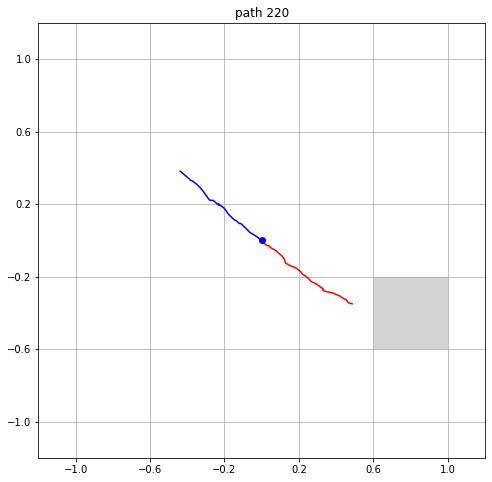

1 0


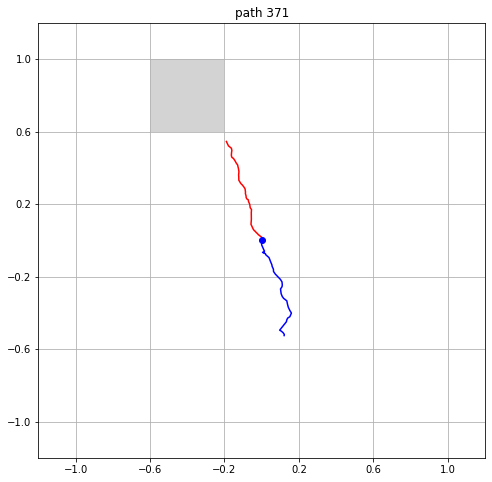

4 1


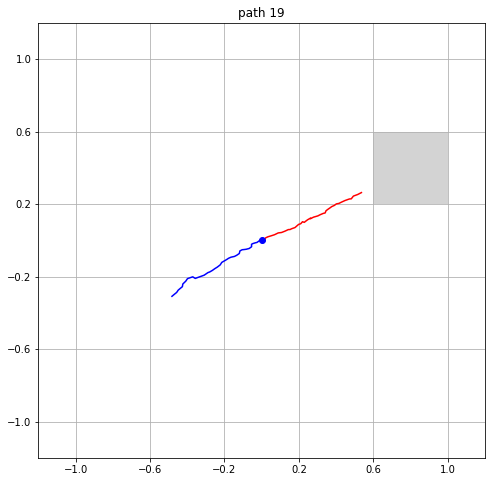

In [74]:
def draw_path(x, ground_truth, goals=None, prediction_model=None, n=1, rnd=False):
    """
    Draws the path.
    Inputs:
        x - (batch, input-time-steps, features) matrix of positions
        ground_truth - (batch, output-time-steps, features) matrix
        goals - (batch, one-hot-vector)
        prediction_model - model to use for predictions
        n - number of plots to generate
        rnd - wether the batch should be chosen randomly
    """
    assert(x.shape[0] == ground_truth.shape[0])

    for i in range(n):
        batch_index = i
        if rnd:
            batch_index = random.randrange(0, x.shape[0])
        
        x_batch = x[batch_index]
        gt_batch = ground_truth[batch_index]

        x_batch_xvals = x_batch[:,0]
        x_batch_yvals = x_batch[:,1]
        gt_batch_xvals = gt_batch[:,0]
        gt_batch_yvals = gt_batch[:,1]

        # position robot is currently in
        current_x = x_batch_xvals[-1]
        current_y = x_batch_yvals[-1]

        fig, ax = plt.subplots()
        fig.set_size_inches(8.0, 8.0)

        # if goal is given then draw that
        if goals is not None:
            goal_batch = goals[batch_index]
            # show maximum index as the goal position
            goal_index = goal_batch.argmax()

            goal_index_x, goal_index_y = _goal_index_to_xy_indices(goal_index)
            scaling_factor = 0.4
            print(goal_index_x, goal_index_y)
            rect = patches.Rectangle((goal_index_x*scaling_factor - 1, -goal_index_y*scaling_factor + 0.6), 0.4, 0.4, facecolor='lightgray')
            ax.add_patch(rect)

        ax.set_xticks([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
        ax.set_yticks([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)

        # draw past path
        ax.plot(x_batch_xvals, x_batch_yvals, 'b')
        # draw future path
        ax.plot(gt_batch_xvals, gt_batch_yvals, 'r')

        # if we have the prediction model then generate a prediction and draw it
        if prediction_model:
            prediction_input = x_batch.reshape(1, x_batch.shape[0], x_batch.shape[1])
            prediction = prediction_model(prediction_input)[0]
            px = prediction[:,0]
            py = prediction[:,1]
            ax.plot(px, py, 'g')
            # print(prediction)

        # draw current position point
        ax.plot(current_x, current_y, 'bo')

        plt.title("path {}".format(batch_index))
        plt.xlim([-1.2, 1.2])
        plt.ylim([-1.2, 1.2])
        plt.show()

# prediction = multi_conv_model(eval)
draw_path(eval_data[0], eval_data[2], n=3, goals=eval_data[1], prediction_model=model, rnd=True)

In [57]:
def test_model(model, test_data):
    """
    Evaluates model with test data.
    """
    x = test_data[0]
    y = test_data[2]
    loss = model.evaluate(x=x, y=y, verbose=True)
    print("Test loss is {}".format(loss))

test_model(model, test_data)

4/4 [==============================] - 0s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0627
Test loss is [0.0072458828799426556, 0.06269398331642151]
